In [4]:
import json
import os

# 🔽 Replace with your real username and key
kaggle_details = {
    "username": "princek9109",
    "key": "KGAT_b1f7e0ce0410d53c9a574b864501b5e7"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_details, f)

# Set correct permissions
!chmod 600 /root/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 96% 143M/149M [00:00<00:00, 1.50GB/s]
100% 149M/149M [00:00<00:00, 1.46GB/s]


In [6]:
!unzip brain-tumor-mri-dataset.zip -d brain_tumor_mri

Streaming output truncated to the last 5000 lines.
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0712.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0713.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0714.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0724.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0725.jpg  
  inflating: brain_tumor_mri/Training/glioma/Tr-gl_0726.jpg  
  inflating: brain_

In [7]:
# Set the path to the dataset
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/content/brain_tumor_mri/Training")
test_dir = os.path.join(dataset_path, "/content/brain_tumor_mri/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

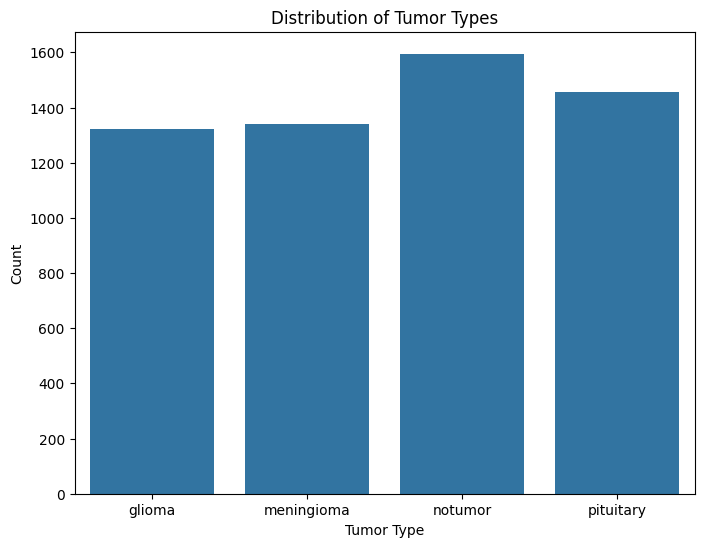

In [9]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

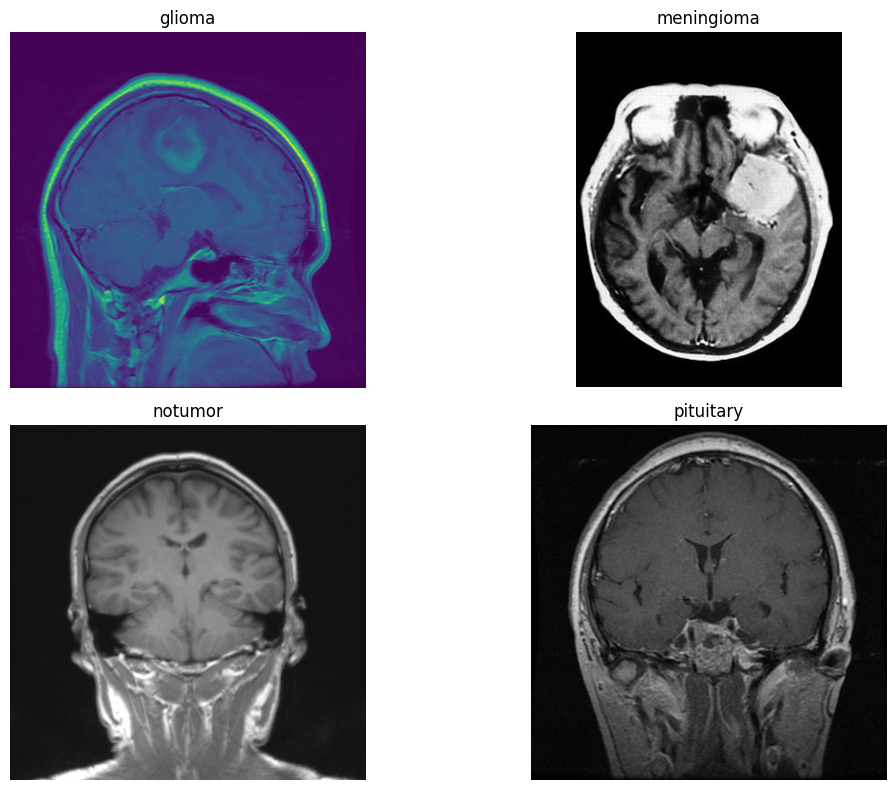

In [10]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [12]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [13]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 56s 273ms/step - accuracy: 0.4767 - loss: 1.0865 - val_accuracy: 0.5242 - val_loss: 1.3394
Epoch 2/50
  1/178 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7188 - loss: 0.7667

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7188 - loss: 0.7667 - val_accuracy: 0.4992 - val_loss: 1.4333
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.6886 - loss: 0.7704 - val_accuracy: 0.5445 - val_loss: 1.1862
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7500 - loss: 0.5894 - val_accuracy: 0.5586 - val_loss: 1.1459
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.7538 - loss: 0.6332 - val_accuracy: 0.7523 - val_loss: 0.6316
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7188 - loss: 0.6044 - val_accuracy: 0.7664 - val_loss: 0.5919
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - accuracy: 0.7807 - loss: 0.5696 - val_accuracy: 0.6867 - val_loss: 0.9106
Epoch 8/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8125 - loss: 0.7457 - val_accuracy: 0.7422 - val_loss: 0.6802
Epoch 9/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.7988 - loss: 0.5182 - val_accurac

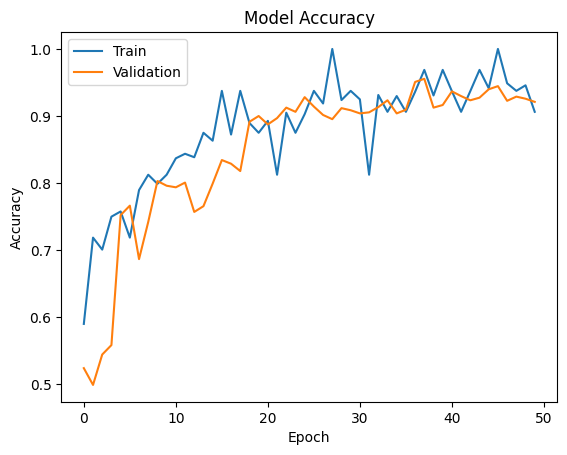

In [15]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

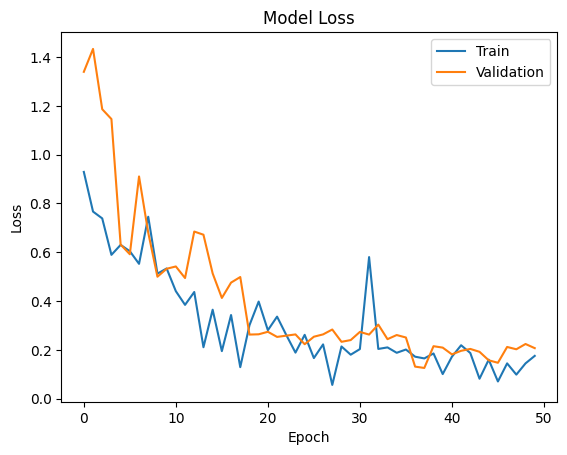

In [16]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [17]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8871 - loss: 0.2981
Test Loss: 0.20717866718769073
Test Accuracy: 0.921093761920929


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step


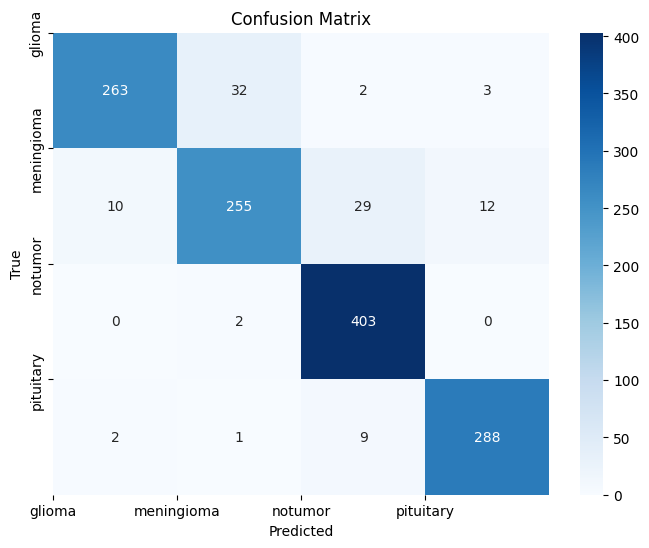

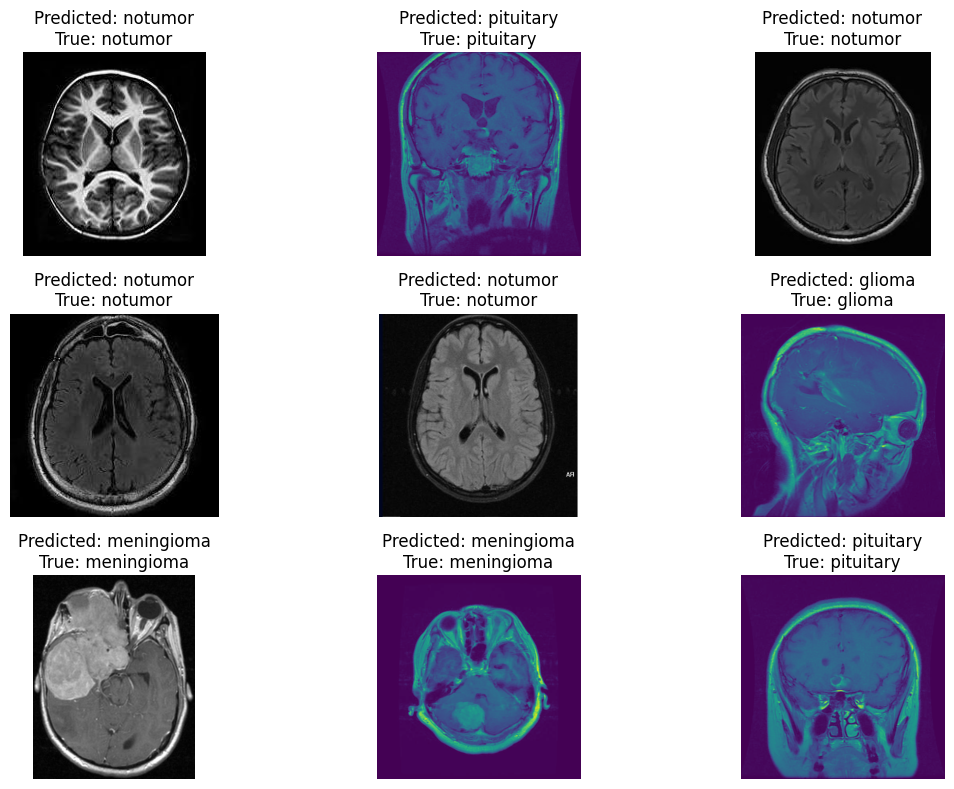

In [18]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9563636363636364
Recall: 0.8766666666666667
F1-Score: 0.9147826086956522

Class: meningioma
Precision: 0.8793103448275862
Recall: 0.8333333333333334
F1-Score: 0.8557046979865771

Class: notumor
Precision: 0.909706546275395
Recall: 0.9950617283950617
F1-Score: 0.9504716981132074

Class: pituitary
Precision: 0.9504950495049505
Recall: 0.96
F1-Score: 0.9552238805970149



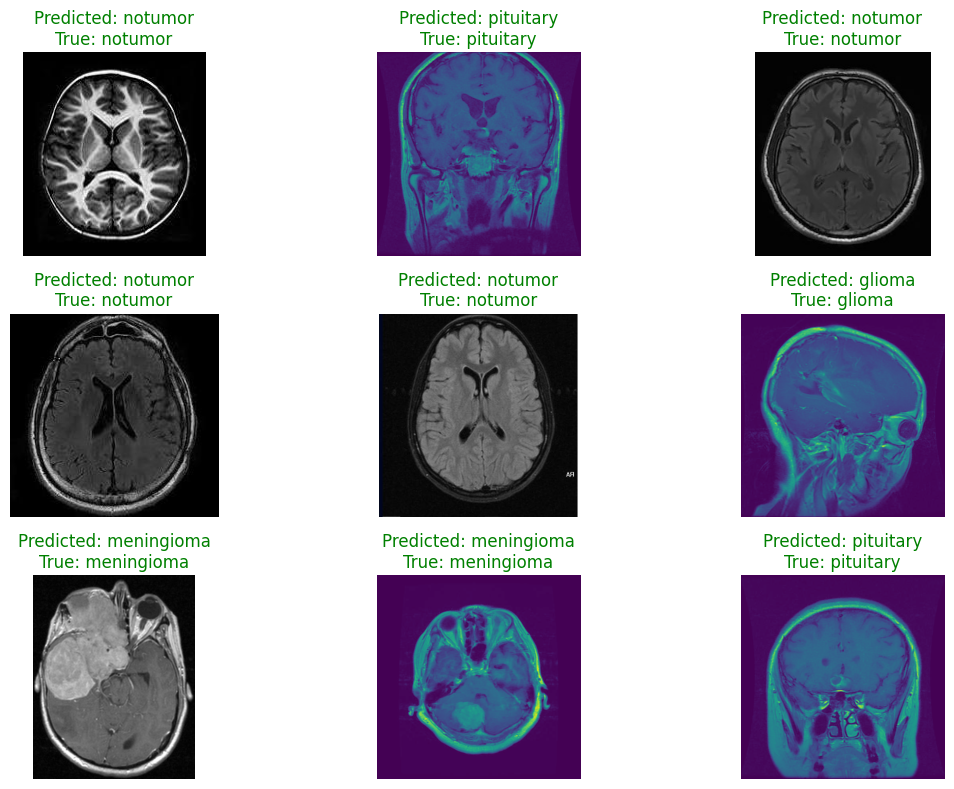

In [19]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()